# A Transformer-based recommendation system


In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
from src.dataset import RatingDataset
from src import utils
from torch.utils.data import DataLoader
from torch import nn
import torch
from tqdm import tqdm
import numpy as np
import os

## (1) Model Config

In [3]:
# inputs

In [4]:
age_group_id_map_dict = utils.open_object("./artifacts/age_group_id_map_dict.pkl")

movie_id_map_dict = utils.open_object("./artifacts/movie_id_map_dict.pkl")

occupation_id_map_dict = utils.open_object("./artifacts/occupation_id_map_dict.pkl")

sex_id_map_dict = utils.open_object("./artifacts/sex_id_map_dict.pkl")

user_id_map_dict = utils.open_object("./artifacts/user_id_map_dict.pkl")
# genres_map_dict = utils.open_object("./artifacts/genres_map_dict.pkl")

In [5]:
rating_min_max_scaler = utils.open_object("./artifacts/rating_min_max_scaler.pkl")

In [6]:
num_user = len(user_id_map_dict)
num_movie = len(movie_id_map_dict)
num_occupation = len(occupation_id_map_dict)
num_age_group = len(age_group_id_map_dict)
# num_genre = len(genres_map_dict)

In [7]:
embed_configs = {}
EMED_DIM=32
sequence_length=4
embed_configs['user']={"embed_dim":EMED_DIM,"num_embed":num_user}
embed_configs['movie']={"embed_dim":EMED_DIM,"num_embed":num_movie}
embed_configs['occupation']={"embed_dim":EMED_DIM,"num_embed":num_occupation}
embed_configs['age_group']={"embed_dim":EMED_DIM,"num_embed":num_age_group}
embed_configs['position'] = {"embed_dim":EMED_DIM,"num_embed":sequence_length}

In [8]:
config_dict={}
config_dict['embed_configs'] = embed_configs
config_dict['transformer_num_layer']=3
config_dict['dropout']=0.2
config_dict['epoches']=10
config_dict['learning_rate']=0.001
config_dict['batch_size']=64

In [9]:
class Config:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            setattr(self, key, value)

In [10]:
config = Config(dictionary=config_dict)

In [11]:
config.embed_configs

{'user': {'embed_dim': 32, 'num_embed': 6041},
 'movie': {'embed_dim': 32, 'num_embed': 3884},
 'occupation': {'embed_dim': 32, 'num_embed': 22},
 'age_group': {'embed_dim': 32, 'num_embed': 8},
 'position': {'embed_dim': 32, 'num_embed': 4}}

## (3) Load Model




In [12]:
from src.model import BSTRecommender

In [13]:
model = BSTRecommender(config=config)

In [14]:
# loss_func = nn.MSELoss()
loss_func = nn.L1Loss()

## (4) Training

In [15]:
df_train = pd.read_parquet("./artifacts/train_data.parquet")
df_test = pd.read_parquet("./artifacts/test_data.parquet")

In [16]:
train_dataset = RatingDataset(data=df_train) 
test_dataset = RatingDataset(data=df_test)

In [17]:
train_loader = DataLoader(train_dataset,batch_size=config.batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=config.batch_size,shuffle=True)

In [18]:
from src.evaluation import evaluate

In [19]:
before_training_metrics = evaluate(model,test_loader,loss_func=loss_func)
print(before_training_metrics)

100%|██████████| 1166/1166 [00:06<00:00, 181.30it/s]

{'eval_loss': 0.255823514793279}


In [20]:
optimizer = torch.optim.AdamW(model.parameters(),lr=config.learning_rate)

In [21]:
total_batch = 0
best_eval_loss =  float("inf")
best_checkpoint = 0

In [22]:
model_version='v1'

In [23]:
config.eval_steps = len(train_loader)//3

In [24]:
# Train
total_pbar = tqdm(total=len(train_loader)*config.epoches,
                  desc="Training", position=0, leave=True)

metrics_list = []

for epoch in range(config.epoches):
    # print("*"*50 + f"epoch: {epoch + 1}" + "*"*50)

    train_loss_list = []
    prob_list = []
    rating_list = []

    for inputs in train_loader:
        model = model.train()
        optimizer.zero_grad()
        probs = model(inputs)

        rating = inputs['target_rating'].view(-1, 1)

        loss = loss_func(probs, rating)
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())

        probs = probs.detach().cpu().numpy().flatten().tolist()
        prob_list.extend(probs)
        rating = rating.numpy().flatten().tolist()
        rating_list.extend(rating)

        if (total_batch+1) % config.eval_steps == 0:

            improve = False
            model_metrics = evaluate(model, test_loader)
            eval_loss = model_metrics['eval_loss']

            if eval_loss <= best_eval_loss:
                improve = True
                best_checkpoint = total_batch+1
                best_eval_loss = eval_loss

            train_loss = np.mean(train_loss_list)
            
            model_metrics['best_eval_loss'] = best_eval_loss
            model_metrics['train_loss'] = train_loss
            model_metrics["steps"] = total_batch+1
            model_metrics["best_checkpoint"] = best_checkpoint
            metrics_list.append(model_metrics)
                
            if improve:
                save_dir = os.path.join("model", model_version)
                os.makedirs(save_dir, exist_ok=True)
                model_path = utils.save_model(model, save_dir, total_batch+1, model_metrics)
            
            post_fix_message = {k:round(v,3) for k,v in model_metrics.items()}
            total_pbar.set_postfix(post_fix_message)


            model = model.train()

        total_batch += 1
        total_pbar.update(1)

    model = model.train()

total_pbar.close()

Training: 100%|██████████| 66260/66260 [16:32<00:00, 66.77it/s, eval_loss=0.169, best_eval_loss=0.169, train_loss=0.152, steps=66240, best_checkpoint=66240]


In [34]:
df_metrics = pd.DataFrame(metrics_list)
df_metrics

,eval_loss,best_eval_loss,train_loss,steps,best_checkpoint
0,0.183746,0.183746,0.193818,2208,2208
1,0.181825,0.181825,0.188021,4416,4416
2,0.175140,0.175140,0.184953,6624,6624
3,0.175165,0.175140,0.172426,8832,6624
4,0.173545,0.173545,0.173233,11040,11040
5,0.173339,0.173339,0.173385,13248,13248
6,0.172285,0.172285,0.167968,15456,15456
7,0.172461,0.172285,0.168829,17664,15456
8,0.170762,0.170762,0.169496,19872,19872
9,0.171665,0.170762,0.165595,22080,19872


<Axes: xlabel='steps'>

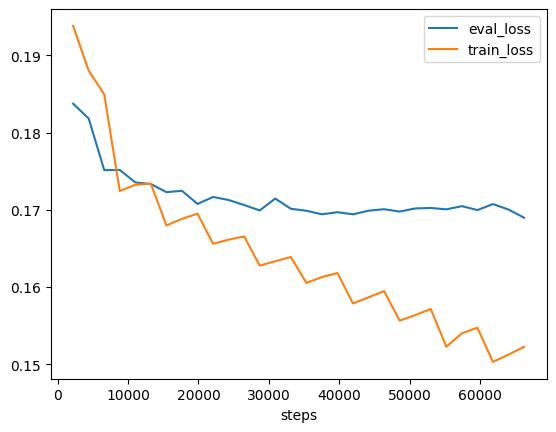

In [35]:
df_metrics = df_metrics.set_index("steps")


# fig, ax = plt.subplots(figsize=(20,10)) 
df_metrics[['eval_loss','train_loss']].plot() 


## (5)Load Best Model For Evaluation

In [69]:
best_model_path = f"{save_dir}/checkpoint-66240/pytorch_model.pt"

In [70]:
best_model = BSTRecommender(config=config)

In [71]:
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

BSTRecommender(
  (embedding_layers): ModuleDict(
    (user): Embedding(6041, 32)
    (movie): Embedding(3884, 32)
    (occupation): Embedding(22, 32)
    (age_group): Embedding(8, 32)
    (position): Embedding(4, 32)
  )
  (transformer_layer): TransformerLayer(
    (transformer_blocks): ModuleList(
      (0-2): 3 x TransformerBlock(
        (multihead_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=64, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
        (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (mlp): MLP(
    (dropout): Dropout(p=

In [72]:
from sklearn import metrics

In [73]:
best_model.eval()
prob_list= []
rating_list = []
eval_loss_list = []
pbar = tqdm(total = len(test_loader),desc = "",position=0, leave=True)
for inputs in test_loader:
    with torch.no_grad():
        probs = best_model(inputs)
        ratings = inputs['target_rating'].view(-1,1)
        
        loss = loss_func(probs, ratings)
        eval_loss_list.append(loss.item())

        probs = probs.cpu().numpy().flatten().tolist()
        prob_list.extend(probs)

        ratings = ratings.numpy().flatten().tolist()
        rating_list.extend(ratings)

        pbar.update(1)

 98%|█████████▊| 1147/1166 [00:06<00:00, 190.84it/s]

In [74]:
prediction = pd.DataFrame()

In [75]:
prediction['real']=rating_min_max_scaler.inverse_transform(np.array(rating_list).reshape(-1,1))[:,0]
prediction['prediction']=rating_min_max_scaler.inverse_transform(np.array(prob_list).reshape(-1,1))[:,0]

In [76]:
metrics.mean_absolute_error(prediction['real'],prediction['prediction'])

0.6759676782243109

In [77]:
metrics.mean_squared_error(prediction['real'],prediction['prediction'])

0.9018125666425599

In [78]:
"""show result: the model seems very good"""
prediction.iloc[:50]

,real,prediction
0,5.0,3.971718
1,5.0,4.167025
2,3.0,4.129578
3,3.0,3.158442
4,4.0,4.002030
5,4.0,4.073769
6,4.0,2.992556
7,5.0,4.038979
8,4.0,2.709585
9,3.0,3.930278


100%|██████████| 1166/1166 [00:19<00:00, 190.84it/s]